# MNIST Image Classification with TensorFlow

This notebook demonstrates how to implement a simple linear image models on MNIST using Estimator.
<hr/>
This <a href="mnist_models.ipynb">companion notebook</a> extends the basic harness of this notebook to a variety of models including DNN, CNN, dropout, pooling etc.

In [1]:
import numpy as np
import shutil
import os
import tensorflow as tf
print(tf.__version__)

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


## Exploring the data

Let's download MNIST data and examine the shape. We will need these numbers ...

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("mnist/data", one_hot = True, reshape = False)
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [3]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


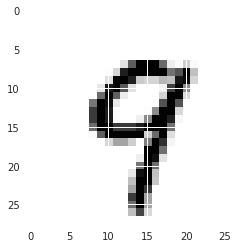

In [4]:
import matplotlib.pyplot as plt
IMGNO = 12
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

## Define the model.
Let's start with a very simple linear classifier. All our models will have this basic interface -- they will take an image and return logits.

In [6]:
def linear_model(img):
    X = tf.reshape(tensor = img, shape = [-1, HEIGHT * WIDTH]) #flatten
    ylogits = tf.layers.dense(inputs = X, units = NCLASSES, activation = None)
    return ylogits, NCLASSES

## Write Input Functions

As usual, we need to specify input functions for training, evaluation, and predicition.

In [7]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"image": mnist.train.images},
    y = mnist.train.labels,
    batch_size = 100,
    num_epochs = None,
    shuffle = True,
    queue_capacity = 5000
)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"image": mnist.test.images},
    y = mnist.test.labels,
    batch_size = 100,
    num_epochs = 1,
    shuffle = False,
    queue_capacity = 5000
)

def serving_input_fn():
    inputs = {"image": tf.placeholder(dtype = tf.float32, shape = [None, HEIGHT, WIDTH])}
    features = inputs # as-is
    return tf.estimator.export.ServingInputReceiver(features = features, receiver_tensors = inputs)

## Write Custom Estimator
I could have simply used a canned LinearClassifier, but later on, I will want to use different models, and so let's write a custom estimator

In [8]:
def image_classifier(features, labels, mode, params):
    ylogits, nclasses = linear_model(features["image"])
    probabilities = tf.nn.softmax(logits = ylogits)
    class_ids = tf.cast(x = tf.argmax(input = probabilities, axis = 1), dtype = tf.uint8)

    if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
        loss = tf.reduce_mean(input_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(logits = ylogits, labels = labels))
        
        if mode == tf.estimator.ModeKeys.TRAIN:
            train_op = tf.contrib.layers.optimize_loss(
                loss = loss, 
                global_step = tf.train.get_global_step(),
                learning_rate = params["learning_rate"], 
                optimizer = "Adam")
            eval_metric_ops = None
        else:
            train_op = None
            eval_metric_ops =  {"accuracy": tf.metrics.accuracy(labels = tf.argmax(input = labels, axis = 1), predictions = class_ids)}
    else:
        loss = None
        train_op = None
        eval_metric_ops = None
 
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = {"probabilities": probabilities, "class_ids": class_ids},
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops,
        export_outputs = {"predictions": tf.estimator.export.PredictOutput({"probabilities": probabilities, "class_ids": class_ids})}
    )

 tf.estimator.train_and_evaluate does distributed training.

In [9]:
def train_and_evaluate(output_dir, hparams):
    estimator = tf.estimator.Estimator(
        model_fn = image_classifier,
        model_dir = output_dir,
        params = hparams)

    train_spec = tf.estimator.TrainSpec(
        input_fn = train_input_fn,
        max_steps = hparams["train_steps"])

    exporter = tf.estimator.LatestExporter(name = "exporter", serving_input_receiver_fn = serving_input_fn)

    eval_spec = tf.estimator.EvalSpec(
        input_fn = eval_input_fn,
        steps = None,
        exporters = exporter)

    tf.estimator.train_and_evaluate(estimator = estimator, train_spec = train_spec, eval_spec = eval_spec)

This is the main() function

In [10]:
OUTDIR = "mnist/learned"
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time

hparams = {"train_steps": 1000, "learning_rate": 0.01}
train_and_evaluate(OUTDIR, hparams)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_train_distribute': None, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdca2722240>, '_model_dir': 'mnist/learned', '_keep_checkpoint_max': 5, '_session_config': None, '_global_id_in_cluster': 0, '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_log_step_count_steps': 100, '_save_summary_steps': 100, '_tf_random_seed': None, '_is_chief': True, '_service': None, '_save_checkpoints_steps': None, '_task_type': 'worker', '_evaluation_master': '', '_num_ps_replicas': 0}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorfl

What accuracy did you achieve?

<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>